Daniël van der Schuur - 1811230  
Jonas Moons - Fundamentals of Machine Learning  
26-08-2022  

In [2]:
# General imports
import json 
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np # linear algebra
import seaborn as sns
import pytz

# Sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans #The k-means algorithm
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

# Scraper imports
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import NoSuchElementException   
# from agentfinder import agent_finder # Can be found on the github repo for the scraper
# from agentfinder import class_finder # Can be found on the github repo for the scraper
import re
import time


# Machine Learning 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Predictive Model - Team Composition in Valorant

## Introduction
The concept revolves around Valorant, a tactical 5-man team shooter.The game consists of rounds, and the team that gets 13 rounds first wins.  
The game consists of an array of variables, what characters (agents) the team picks (every character has a set of unique abilities), the role each agent fulfills, the map being played, and personal performance. By gathering data from my personal team, the predictive model will seek out the team composition that will have the highest impact on the game.

The game currently has 20 agents categorized in 4 roles being:  
- Duelist - The abilities of agents under this role focus on being the first to enter sites and engage the enemy.
- Initiator - The abilities of agents under this role focus on flushing enemies out of hiding spots and corners in order to assist the team when charging into battle.
- Controller - The abilities of agents under this role allow them to assist their teammates by cutting enemy vision, taking control of an area, and forcing enemies into choke points.
- Sentinel - The abilities of agents under this role focus on defensive play, with emphasis on supporting the rest of the team through providing intel, anchoring down sites, and preventing the enemy from flanking.

Given this, the research question set out to answer is: Can a predictive model predict which agent will yield the highest win rate per username per map?

## Data set
Data is scraped from tracker.gg a website that gives insight into games played, specifically from Valorant (e.g. https://tracker.gg/valorant/profile/riot/sjonkie%23bluk/overview).  
The webscraper using selenium can be found here: https://github.com/sjerrietukkel/val_tracker_scraper  

The data represents games played by an individual player, every player will have around 100 games, due to a limitation of the scraper. The final dataset (500 rows) consists of every player combined and will thus represent the team effort and performance. The data sets used represent the 5-stack team that I personally play with. 

### Data Scraper

In [3]:
# driver = webdriver.Chrome(ChromeDriverManager().install()) # Install the Chrome driver for Selenium
# data = [] # Initialize the data array
# username = str(input("Input username: "))
# hash = str(input("Input hash: ")) # hash is used to grab the data from the website
# URL = f"https://tracker.gg/valorant/profile/riot/{username}%23{hash}/matches" # The URL to scrape

# driver.get(URL)
# driver.implicitly_wait(5) #allow some time to fully load the page


# def check_exists_by_xpath(xpath): # Check if the element exists
#     time.sleep(1) # Wait for the page to load
#     try:
#         driver.find_element_by_xpath(xpath)
#         print("Located and clicked 'Load More'...")
#     except NoSuchElementException: # If the element does not exist, then the exception is thrown
#         print("Func NSE, proceed to retrieve data...")
#         return False
#     return True

# loadMoreButton = driver.find_element_by_xpath('//span[@class="trn-gamereport-list__group-more"]') # Find the load more button
# while check_exists_by_xpath('//span[@class="trn-gamereport-list__group-more"]') == True: # While the button exists (i.e. the page is not the last page) presses button.
#     time.sleep(2)
#     loadMoreButton.click()

# if check_exists_by_xpath('//span[@class="trn-gamereport-list__group-more"]') == False:  # If the button does not exist, then the page is the last page. So, we can stop.
#     print('Retrieving data ...')
#     time.sleep(2)
#     matches = driver.find_elements_by_css_selector(r'[class="match__row"]') # Find all the matches
#     i = 1
#     for match in matches:                                 # For each match in the page get data from corresponding selectors
#         title = match.find_element_by_css_selector('span.match__name')
#         title = title.text
#         time_match = match.find_element_by_css_selector('span.match__time')
#         time_match = time_match.text
#         mode = match.find_element_by_css_selector('div.match__subtitle')
#         mode = mode.text
#         score_won = match.find_element_by_css_selector('span.score--won')
#         score_won = score_won.text
#         score_lost = match.find_element_by_css_selector('span.score--lost')
#         score_lost = score_lost.text
#         placement = match.find_element_by_css_selector('div.badge')
#         placement = placement.text
#         agent_url = match.find_element_by_css_selector('.match__portrait img').get_attribute('src')
#         kda = match.find_element_by_css_selector('div.match__row-stats > div:nth-of-type(1) > div.value')
#         kda = kda.text
#         kd = match.find_element_by_css_selector('div.match__row-stats > div:nth-of-type(2) > div.value')
#         kd = kd.text
#         kd = float(kd)
#         hs = match.find_element_by_css_selector('div.match__row-stats > div:nth-of-type(3) > div.value')
#         hs = hs.text
#         hs = float(hs)
#         adr = match.find_element_by_css_selector('div.match__row-stats > div:nth-of-type(4) > div.value')
#         adr = adr.text
#         adr = int(adr)
#         acs = match.find_element_by_css_selector('div.match__row-stats > div:nth-of-type(4) > div.value')
#         acs = acs.text
#         acs = int(acs)
#         print(f'Data append: {i}')
#         win = True

#         if placement == "MVP":
#             placement = 1
#         else:
#             placement = re.sub("[^0-9]", "", placement)
#             placement = int(placement)

#         kda = kda.split(sep="/")
#         k = int(kda[0])
#         d = int(kda[1])
#         a = int(kda[2])

#         score_won = int(score_won)
#         score_lost = int(score_lost)

#         if score_won <= score_lost:
#             win = False         # draw is considered as a loss

#         agent = agent_finder(agent_url) # Agent was provided as a img, func finds corresponding str
#         role = class_finder(agent_url) # Agent was provided as a img, func finds corresponding str
#         match_json = { # Create a dictionary with the data
#             'id' : i,
#             'map': title,
#             'agent': agent,
#             'class': role,
#             'time': time_match, 
#             'mode': mode,
#             'score_won': score_won,
#             'score_lost': score_lost,
#             'win' : win, 
#             'placement': placement,
#             'kills' : k,
#             'deaths' : d,
#             'assists': a,
#             'kd_percentage' : kd,
#             'hs_percentage' : hs,
#             'damage_per_round' : adr,
#             'combat_score_total' : acs,
#             'username': username,
#         }
#         i = i + 1 # Increment the counter for total match, capped at 200 because of time limit of the website
#         data.append(match_json)
#         if i == 201:
#             break
# time.sleep(1)
# print('Data succesfully appended.')

# filename = f'data/priv_data/game_data_{username}.json'
# with open (filename, 'w') as outfile:
#     json.dump(data, outfile)
# driver.quit()

### Data Output
Outputs a seperate json file per player with games played.

```js
[
    {
        "id": 81,
        "map": "Breeze",
        "agent": "Omen",
        "class": "Controller",
        "time": "08:30 PM",
        "mode": "Competitive",
        "score_won": 13,
        "score_lost": 8,
        "win": true,
        "placement": 1,
        "kills": 29,
        "deaths": 13,
        "assists": 7,
        "kd_percentage": 2.2,
        "hs_percentage": 16.0,
        "damage_per_round": 309,
        "combat_score_total": 411,
        "username": "sjonkie"
  }
]
```

### Data Merge

In order to import this in a pandas dataframe all individual user games should be merged into 1 json file that can be read as 'df'

In [4]:
def merge_JsonFiles(): # Merge all data files in to one
    result = list()
    for filename in glob.glob('priv_data/*.json', recursive=False):
        with open(filename, 'r') as infile:
            result.extend(json.load(infile))
    with open('priv_data/combined/combined_matches.json', 'w') as output_file:
        json.dump(result, output_file)
total_matches = merge_JsonFiles()

df = pd.read_json('priv_data/combined/combined_matches.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  575 non-null    int64  
 1   map                 575 non-null    object 
 2   agent               575 non-null    object 
 3   class               575 non-null    object 
 4   time                575 non-null    object 
 5   mode                575 non-null    object 
 6   score_won           575 non-null    int64  
 7   score_lost          575 non-null    int64  
 8   win                 575 non-null    bool   
 9   placement           575 non-null    int64  
 10  kills               575 non-null    int64  
 11  deaths              575 non-null    int64  
 12  assists             575 non-null    int64  
 13  kd_percentage       575 non-null    float64
 14  hs_percentage       575 non-null    int64  
 15  damage_per_round    575 non-null    int64  
 16  combat_s

In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,575.0,NaN,NaN,NaN,62.092174,39.278779,1.0,29.0,58.0,91.5,151.0
map,575,7,Icebox,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agent,575,19,Chamber,121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,575,4,Sentinel,221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,575,288,10:16 PM,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mode,575,1,Competitive,575,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score_won,575.0,NaN,NaN,NaN,10.777391,3.370167,0.0,9.0,13.0,13.0,16.0
score_lost,575.0,NaN,NaN,NaN,10.457391,3.385948,0.0,8.0,12.0,13.0,15.0
win,575,2,True,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
placement,575.0,NaN,NaN,NaN,5.283478,2.713623,1.0,3.0,5.0,8.0,10.0


# Feature Engineering

### Time of game started

The time of the game being started needed reformatting in order to be useful for Seaborn graphs.  
I choose to give it the current date, since only the time of playing was included in the scraper, not the date of the game.

In [6]:
# turn time into 24 hour format without date
df['time'] = pd.to_datetime(df['time'])
df.drop(["mode"] , axis=1, inplace=True) # not relevant since only competitive games were scraped

### Calculate difference in score

Since not every win/loss is equal, I want to differentiate between larger differences in final scores.

In [7]:
# Calculates team perfomance based on the difference in score
df["result_diff"] = df["score_won"] - df["score_lost"]
df.drop(["score_won", "score_lost"] , axis=1, inplace=True)

def score_indication(score_diff):
    if score_diff > 5:
        return "big win"
    elif score_diff < -5:
        return "big loss"
    elif score_diff > 0:
        return "win"
    elif score_diff < 0:
        return "loss"
    else:
        return "draw"

df["result_indication"] = df["result_diff"].apply(score_indication)
df.head(3)

,id,map,agent,class,time,win,placement,kills,deaths,assists,kd_percentage,hs_percentage,damage_per_round,combat_score_total,username,result_diff,result_indication
0,1,Icebox,Sova,Initiator,2022-08-26 21:19:00,True,8,10,11,4,0.9,11,119,157,BoomeRRemoveR,7,big win
1,2,Bind,Chamber,Sentinel,2022-08-26 20:27:00,False,5,17,20,7,0.8,12,146,214,BoomeRRemoveR,-2,loss
2,3,Bind,Sova,Initiator,2022-08-26 22:16:00,False,7,14,17,7,0.8,11,125,188,BoomeRRemoveR,-4,loss


### Relative performance indicator per class

Since some classes are more "active" in their playstyle, I choose to give an indication on perfomance relative to the classes played. 



In [8]:
# get average combat score per class
def get_avg_combat_score_per_class(df, class_name):
    return df[df["class"] == class_name]["combat_score_total"].mean()

# store average combat score per class in a dictionary
avg_combat_score_per_class_dict = {}
for class_name in df["class"].unique():
    avg_combat_score_per_class = get_avg_combat_score_per_class(df, class_name)
    avg_combat_score_per_class_dict[class_name] = int(avg_combat_score_per_class)

print(avg_combat_score_per_class_dict)


{'Initiator': 196, 'Sentinel': 204, 'Duelist': 225, 'Controller': 232}


In [9]:
# add performance indicator to dataframe based on combat score and class average
def performance_indication(combat_score_total, class_name):
    if combat_score_total > (avg_combat_score_per_class_dict[class_name] + (avg_combat_score_per_class_dict[class_name] / 2)):
        return "++"
    elif combat_score_total > avg_combat_score_per_class_dict[class_name]:
        return "+"
    elif combat_score_total < (avg_combat_score_per_class_dict[class_name] - (avg_combat_score_per_class_dict[class_name] / 2)):
        return "--"
    elif combat_score_total < avg_combat_score_per_class_dict[class_name]:
        return "-"
    else:
        return "="

df["performance_indication"] = df.apply(lambda row: performance_indication(row["combat_score_total"], row["class"]), axis=1)
df.tail(10)


,id,map,agent,class,time,win,placement,kills,deaths,assists,kd_percentage,hs_percentage,damage_per_round,combat_score_total,username,result_diff,result_indication,performance_indication
565,68,Bind,Sage,Sentinel,2022-08-26 22:15:00,False,8,9,15,2,0.6,8,102,168,LookinGreenToday,-9,big loss,-
566,69,Breeze,Sage,Sentinel,2022-08-26 21:17:00,False,8,17,21,9,0.8,34,116,166,LookinGreenToday,0,draw,-
567,70,Haven,Sage,Sentinel,2022-08-26 20:28:00,False,9,13,18,5,0.7,13,108,174,LookinGreenToday,-2,loss,-
568,71,Fracture,Sage,Sentinel,2022-08-26 22:57:00,False,9,13,20,3,0.7,14,107,158,LookinGreenToday,-2,loss,-
569,72,Ascent,Killjoy,Sentinel,2022-08-26 22:08:00,False,4,18,19,2,0.9,7,141,216,LookinGreenToday,-2,loss,+
570,73,Haven,Killjoy,Sentinel,2022-08-26 21:29:00,False,8,9,16,1,0.6,18,107,150,LookinGreenToday,-6,big loss,-
571,74,Breeze,Sage,Sentinel,2022-08-26 21:05:00,True,10,5,13,8,0.4,7,40,65,LookinGreenToday,3,win,--
572,75,Split,Sage,Sentinel,2022-08-26 22:16:00,False,4,17,16,7,1.1,7,131,235,LookinGreenToday,-6,big loss,+
573,76,Bind,Sage,Sentinel,2022-08-26 21:29:00,True,10,9,15,9,0.6,18,96,150,LookinGreenToday,5,win,-
574,77,Breeze,Sage,Sentinel,2022-08-26 20:30:00,True,10,10,17,5,0.6,9,73,125,LookinGreenToday,5,win,-


Now we define function to grab data per map, agent or username later down the line

In [10]:
# get data per map 
def get_map_data(df, map_name):
    return df[df["map"] == map_name]

# get data per agent 
def get_agent_data(df, agent_name):
    return df[df["agent"] == agent_name]
    
# get data per username
def get_username_data(df, username):
    return df[df["username"] == username] 

br_df = get_map_data(df, "Ascent")
br_df.tail()


,id,map,agent,class,time,win,placement,kills,deaths,assists,kd_percentage,hs_percentage,damage_per_round,combat_score_total,username,result_diff,result_indication,performance_indication
542,45,Ascent,Sage,Sentinel,2022-08-26 13:47:00,True,7,10,11,10,0.9,9,96,147,LookinGreenToday,7,big win,-
550,53,Ascent,Sage,Sentinel,2022-08-26 22:12:00,True,5,18,18,7,1.0,16,150,235,LookinGreenToday,3,win,+
559,62,Ascent,Sage,Sentinel,2022-08-26 20:16:00,True,8,16,16,10,1.0,14,124,195,LookinGreenToday,4,win,-
562,65,Ascent,Reyna,Duelist,2022-08-26 14:40:00,False,2,17,14,2,1.2,18,190,287,LookinGreenToday,-8,big loss,+
569,72,Ascent,Killjoy,Sentinel,2022-08-26 22:08:00,False,4,18,19,2,0.9,7,141,216,LookinGreenToday,-2,loss,+


## Descriptive analysis

### Pair Plot

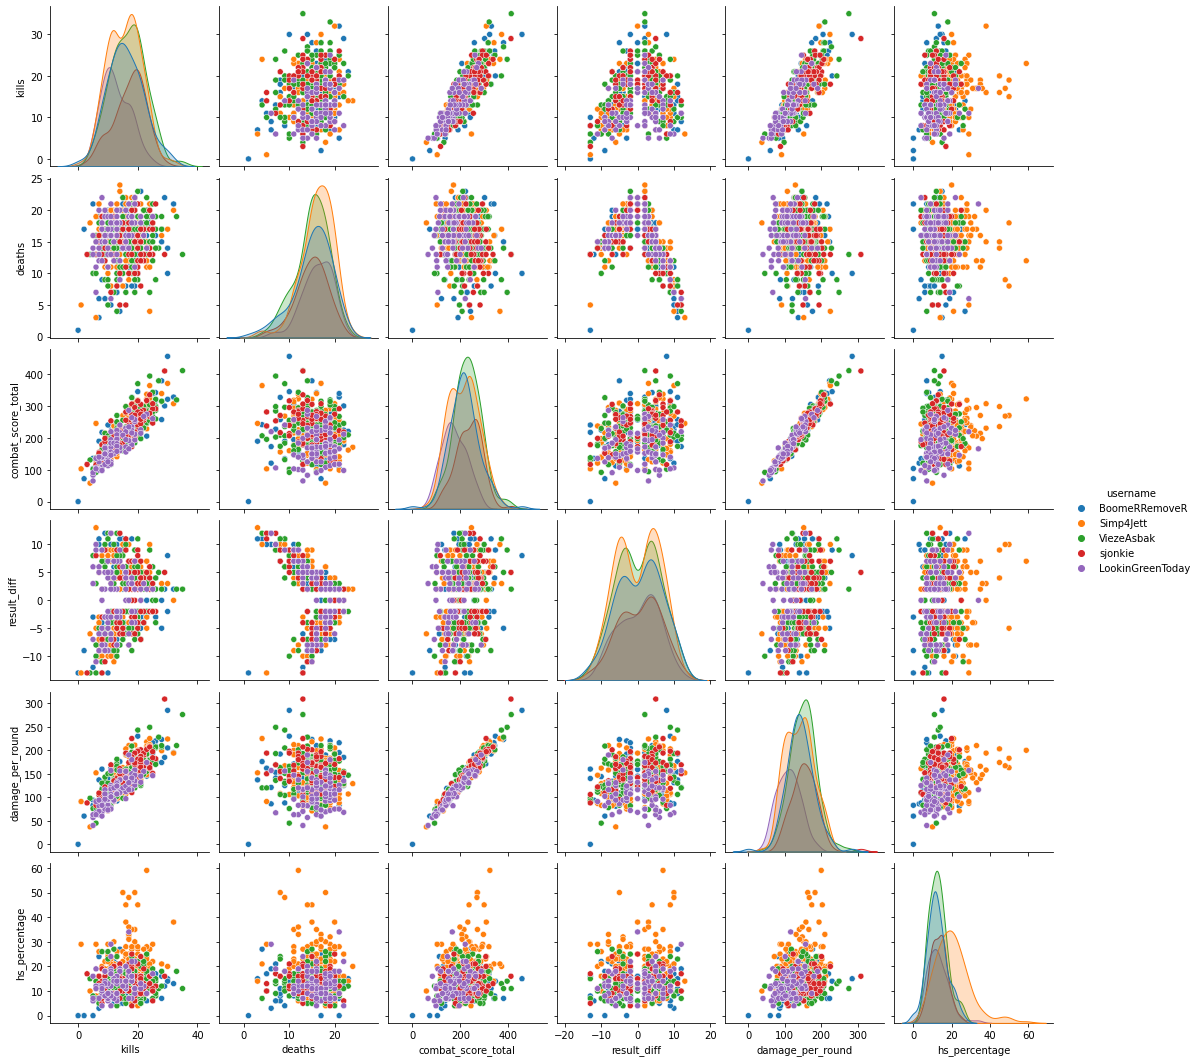

In [11]:
from turtle import title


sns.pairplot(data = df[['kills', 'deaths', 'combat_score_total', 'result_diff', 'damage_per_round', 'agent', 'map', 'hs_percentage', 'username']], hue = 'username')

As seen in the pairplot above, there is quite a big variance in the individual performances per username above all with the rest of the labels being logical. e.g. HS_percentage correlating heavily with the damage per round.  All of the labels show a connection/correlation to each other.

### Correlation Matrix
The number varies from -1 to 1.

1 means that there is a 1 to 1 relationship (a perfect correlation)

0.9 is also a good relationship, and if you increase one value, the other will probably increase as well.

-0.9 would be just as good relationship as 0.9, but if you increase one value, the other will probably go down.

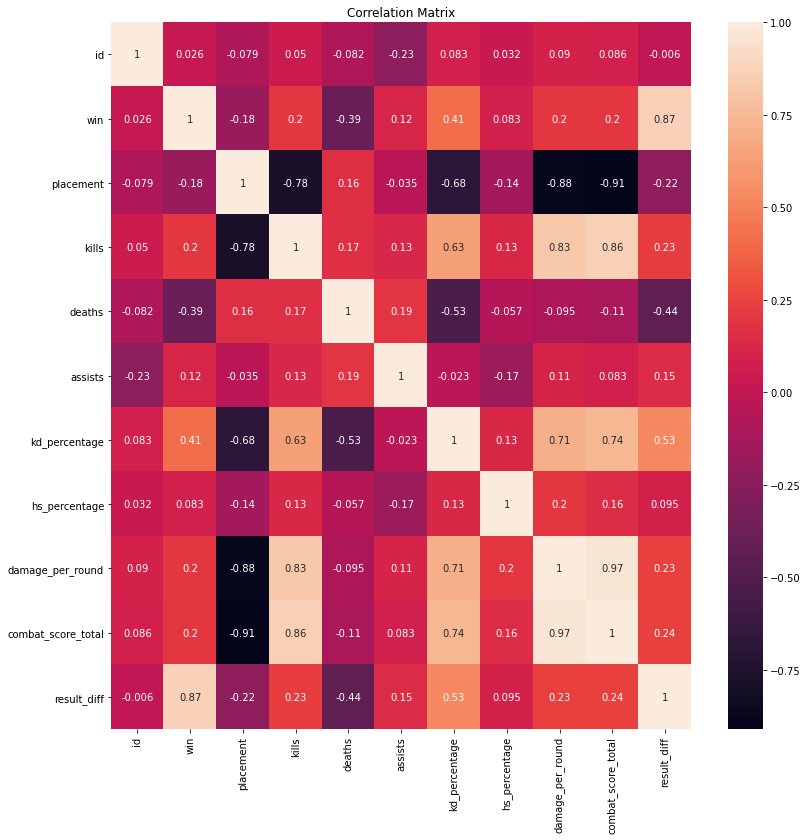

In [12]:
correlation_mat = df.corr()
correlation_mat
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(correlation_mat, annot = True, xticklabels=correlation_mat.columns, yticklabels=correlation_mat.columns, ax=ax)
plt.title('Correlation Matrix')
plt.show()


The correlation matrix shows mostly correlation data that influences the placement after a match is played. As all these columns have influence on the way the game progressed and in turn lead to a win/placement score, most of the labels are correlated.

### Time based performance
I wanted to see if there was a correlation between the time of when a game is played vs the individual combat score. One hickup is the 'time' column that is  not provided in the date, just the time of the matches played was included.


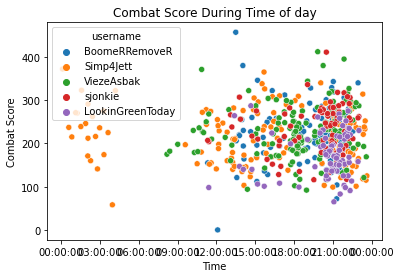

In [13]:
ax = sns.scatterplot(data=df, x='time', y='combat_score_total', hue='username')
ax.set_title('Combat Score During Time of day')
ax.set_xlabel('Time')
ax.set_ylabel('Combat Score')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
plt.rcParams["figure.figsize"] = (30,10)
plt.show()


As we can see there is not a big variety in perfomance or winrate depending on the time. The variety gets bigger later at night, but that could also be attributed to the smaller sample size of those timestamps and the player that had more time on their hands. 

### Linear Regression

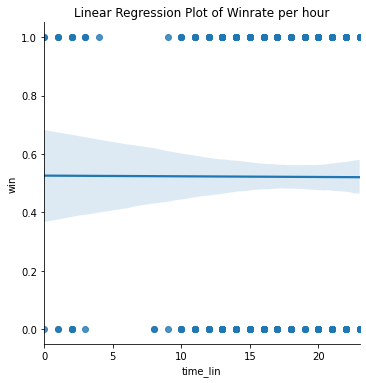

In [14]:
# zet de data om naar uur voor de x as op de linear regression plot
# turn time into 24 hour integer format
from turtle import title


df['time'] = pd.to_datetime(df['time'])
df['time_lin'] = df['time'].dt.hour
df['time_lin'] = df['time_lin'].astype(int)

# plot the linear regression plot
ax = sns.lmplot(x='time_lin', y='win', data=df).set(title='Linear Regression Plot of Winrate per hour')


The linear regression shows a ~0.52 win_rate on the linear regression with a slight deveation in the earlier hours of the day.

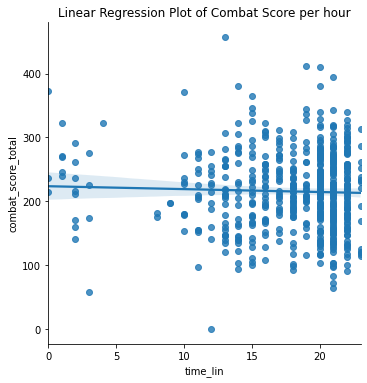

In [15]:
ax = sns.lmplot(x='time_lin', y='combat_score_total', data=df).set(title='Linear Regression Plot of Combat Score per hour')


The linear regression shows a ~210 combat_score on the linear regression with a slight deveation in the earlier hours of the day, dropping down to a 200 combat_score later in the day, but there were more data points at that time.

In [16]:
x = df[['result_diff']] #get the mean steps per person
y = df['combat_score_total'] #get the bmi
lm = LinearRegression() #create a new (empty model)
lm.fit(x, y) #this "fits" the model

b0 = lm.intercept_ #gets the intercept
b1 = lm.coef_[0] #lm.coef_ gets a list of coefficients (excluding the intercept). [0] gets the actual number from the list

print(f"The regression line is equal to y = {b0:.3f} + {b1:.3f}X") #.0f formats to 3 decimals.
lm.predict([[10]]) 


The regression line is equal to y = 214.849 + 2.515X


/Users/danielvanderschuur/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([239.99818362])

In [17]:
df['combat_score_total_p'] = lm.predict(x) #generate the predictions and add them to the dataframe
df['resid'] = df['combat_score_total'] - df['combat_score_total_p'] #get the residuals by subtracting the prediction from the actual value

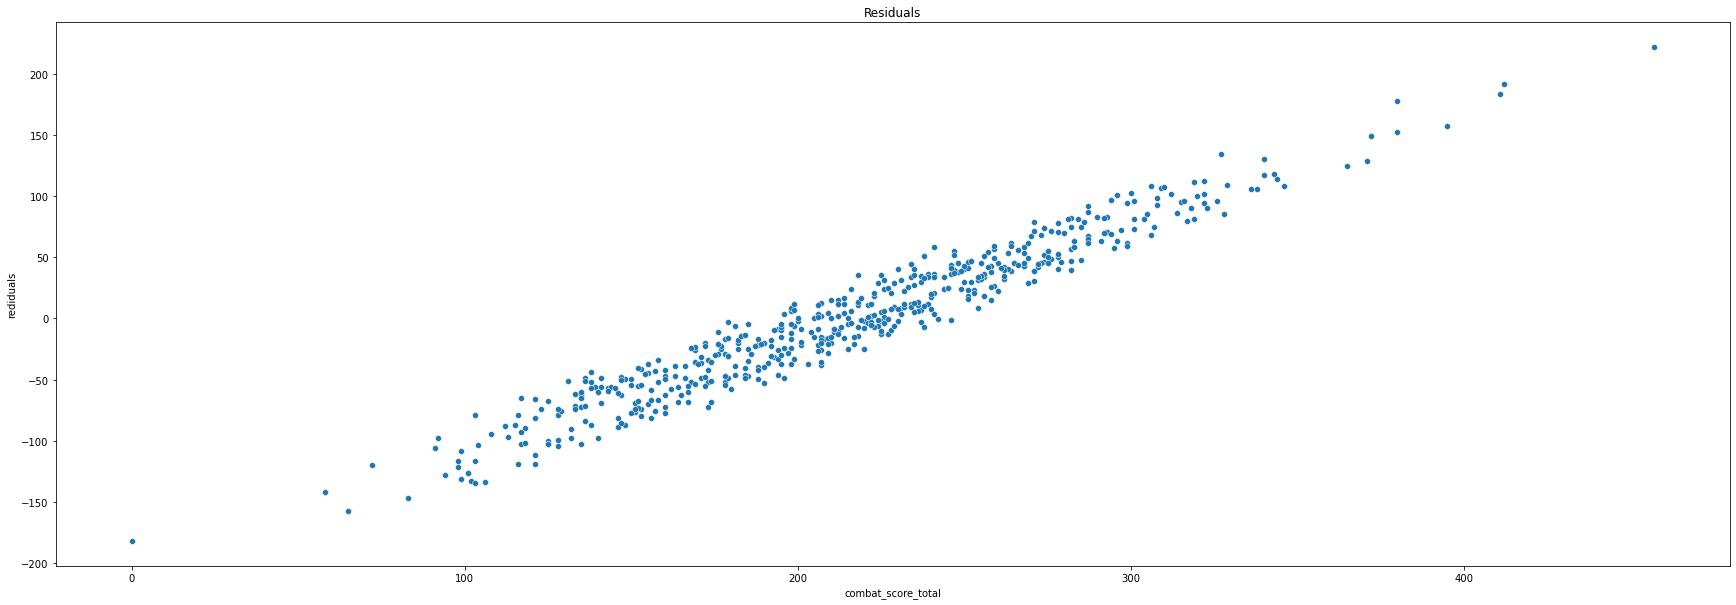

In [18]:
sns.scatterplot(x='combat_score_total',y='resid',data=df)
plt.xlabel('combat_score_total')
plt.ylabel('rediduals')
plt.title('Residuals')
plt.show()

The residuals (The difference between an observed value of the response variable and the value of the response variable predicted from the regression line.) show a clear line, predicting a good fit.

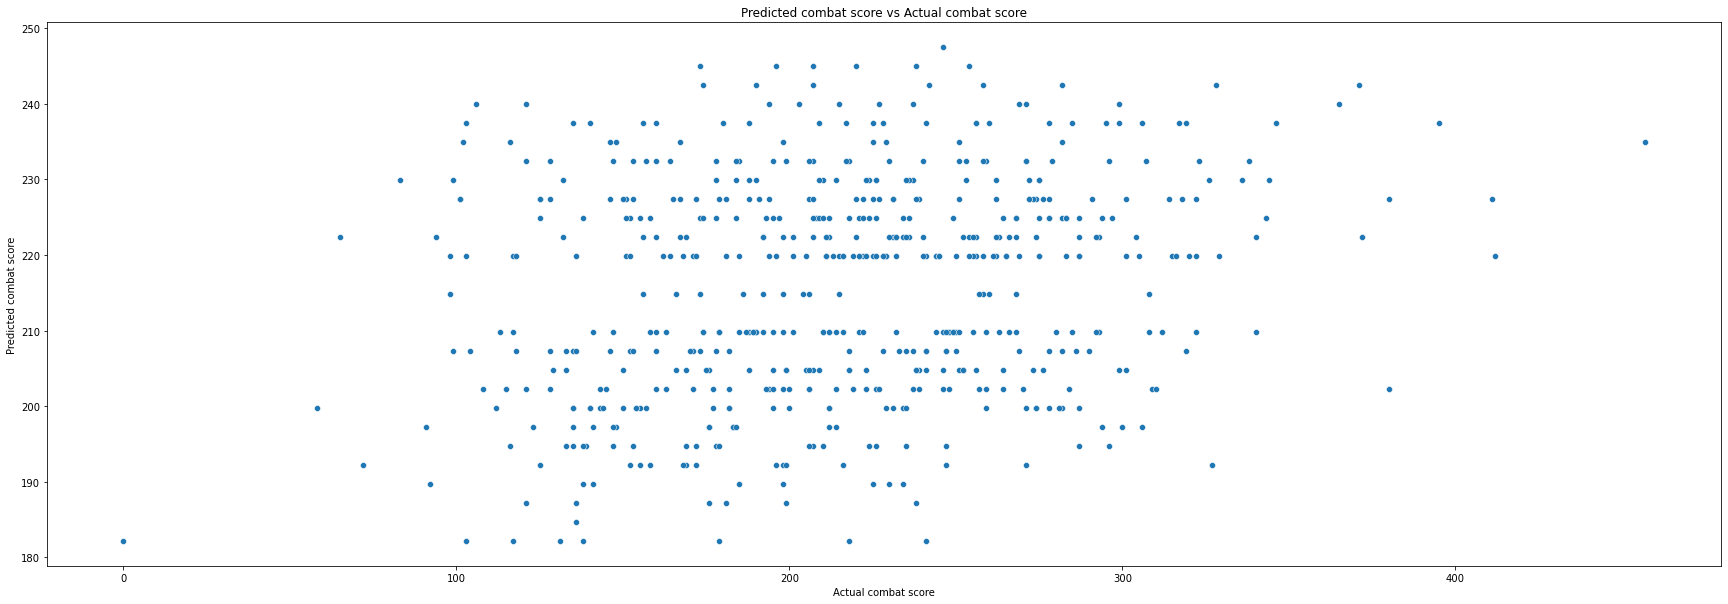

In [19]:
sns.scatterplot(x='combat_score_total',y='combat_score_total_p',data=df)
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Actual combat score')
plt.title('Predicted combat score vs Actual combat score')
plt.ylabel('Predicted combat score')

plt.show()

As shown above in the case of the combat score total and the predicted amount there is a big varience, this indicates a bad fit as a line from bottom left to top right would indicate a good fit. 

In [20]:
r2_score(df['combat_score_total'], df['combat_score_total_p']) #this gives the model fit (R2) for the Y and predicted Y

0.05650159692673684

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.  
R2 = `0.05`  
The R-squared implies there is a .5% accuracy with a simple linear regression. That means that for every one unit increase in combat_score there is a corresponding 0.5-unit increase in predicted_combat_score. 

In [21]:
math.sqrt(mean_squared_error(df['combat_score_total'], df['combat_score_total_p'])) #this gives the model fit (R2) for the Y and predicted Y #this gives the model fit (R2) for the Y and predicted Y

60.07881582252912

Math Squared root square root of the mean square. In this case this is a divergence of 60 combat score. 

## Predictive Model

To create a baseline to compare selected username-agent combination against later we first have to calculate the avarage win_rate per map.

In [22]:
# get winrate per map
def get_winrate_per_map(df, map_name):
    return df[df["map"] == map_name]["win"].mean()

# show win rate per map 
for map_name in df["map"].unique():
    print("{} win rate: {}".format(map_name, get_winrate_per_map(df, map_name)))

Icebox win rate: 0.5869565217391305
Bind win rate: 0.391304347826087
Haven win rate: 0.4861111111111111
Ascent win rate: 0.5853658536585366
Split win rate: 0.5116279069767442
Fracture win rate: 0.5070422535211268
Breeze win rate: 0.5875


Let's focus on individual performance. By creating an average combat score per username we can see how an individual has performed relative to their skill level. We also must grab the most used agents played per username. Since not every player has played every agent. For clearity we store this information, as well as the amount of matches played in a seperate df called `user_df`. This dataframe will be populated with additional map information later.

In [23]:
# calculate average combat score per username
def get_avg_combat_score(df, username):
    return df[df["username"] == username]["combat_score_total"].mean()

# see which class every username uses the most
def get_most_used_class(df, username):
    return df[df["username"] == username]["class"].mode()[0]

def most_used_agents(df, username):
    temp = df[df["username"] == username]["agent"].value_counts()
    temp = temp / len(df["agent"].unique())
    temp = temp * 100
    # only return agents with more than 10% of the total
    return temp[temp > 0].index.tolist()


def performance_calc(df, username, agent):
    i = 0
    if df[df["username"] == username]["performance_indication"].all() == "++":
        i = i + 2
    elif df[df["username"] == username]["performance_indication"].all() == "=":
        i = i + 0
    elif df[df["username"] == username]["performance_indication"].all() == "--":
        i = i - 1
    elif df[df["username"] == username]["performance_indication"].all() == "+":
        i = i + 2
    elif df[df["username"] == username]["performance_indication"].all() == "-":
        i = i - 1
    return i

username_dict = {}
# store every usenrmae in username_dict
for username in df["username"].unique():
    # games played per username
    username_dict[username] = {}
    username_dict[username]["matches_played"] = df[df["username"] == username]["id"].max()
    username_dict[username]["avg_combat_score"] = int(get_avg_combat_score(df, username))
    username_dict[username]["most_used_class"] = get_most_used_class(df, username)
    username_dict[username]["most_used_agents"] = most_used_agents(df, username)

# print(username_dict)
user_df = pd.read_json(json.dumps(username_dict))
user_df.head()

,BoomeRRemoveR,Simp4Jett,ViezeAsbak,sjonkie,LookinGreenToday
matches_played,124,151,142,81,77
avg_combat_score,216,213,229,234,173
most_used_class,Sentinel,Duelist,Duelist,Controller,Sentinel
most_used_agents,"[Chamber, Sova, Fade, Breach, Neon, Killjoy, B...","[Jett, Chamber, Reyna, Yoru, Raze, Neon, Skye,...","[Reyna, Chamber, Killjoy, Sage, Raze, Phoenix,...","[Omen, Brimstone, Sova, Fade]","[Sage, Killjoy, Reyna, Neon, Raze]"


Now let's see the  individual win_rate per username per map and store it in the `user_df`

In [24]:
# win percentage per username per map
def get_agent_win_percentage_per_username_per_map(df, username, map_name):
    return df[(df["username"] == username) & (df["map"] == map_name)]["win"].mean()

for each in df["username"].unique():
    for map_name in df["map"].unique():
        # attadch to username_dict
        username_dict[each][map_name] = get_agent_win_percentage_per_username_per_map(df, each, map_name)

user_df = pd.read_json(json.dumps(username_dict))
user_df.head(10)

,BoomeRRemoveR,Simp4Jett,ViezeAsbak,sjonkie,LookinGreenToday
matches_played,124,151,142,81,77
avg_combat_score,216,213,229,234,173
most_used_class,Sentinel,Duelist,Duelist,Controller,Sentinel
most_used_agents,"[Chamber, Sova, Fade, Breach, Neon, Killjoy, B...","[Jett, Chamber, Reyna, Yoru, Raze, Neon, Skye,...","[Reyna, Chamber, Killjoy, Sage, Raze, Phoenix,...","[Omen, Brimstone, Sova, Fade]","[Sage, Killjoy, Reyna, Neon, Raze]"
Icebox,0.55,0.571429,0.5,0.727273,0.692308
Bind,0.294118,0.444444,0.409091,0.5,0.25
Haven,0.5,0.421053,0.555556,0.538462,0.4
Ascent,0.545455,0.684211,0.6,0.454545,0.6
Split,0.636364,0.380952,0.47619,0.5,0.6
Fracture,0.5,0.588235,0.391304,0.625,0.555556


In the following block of code the win percentage per agent (used by username) per username per map will be added to the dataframe. For clearity and further data normalization, the amount of matches played per agent was also included. 

In [25]:
# get most used classes per column in user_df
def get_most_used_classes_per_column(df, column):
    return df[column]["most_used_agents"]

def asd(df, username, agent, map):
    temp = df[(df["username"] == username) & (df["agent"] == agent) & (df["map"] == map)]["win"].mean()
    temp = round(temp, 2)
    nan_check = math.isnan(temp)
    if nan_check == True:
        return 0.0
    # if temp == 1.0:
    #     return 0.0
    else:    
        return temp

# get most used classes per column in user_df
def get_most_used_classes_per_column(df, column):
    return df[column]["most_used_agents"]

def asd(df, username, agent, map):
    temp = df[(df["username"] == username) & (df["agent"] == agent) & (df["map"] == map)]["win"].mean()
    temp = round(temp, 2)
    nan_check = math.isnan(temp)
    if nan_check == True:
        return 0
    # if temp == 1.0:
    #     return 0
    else:    
        return temp

# this loop is needed to make the code run and prevent np.float64 type errors
for each in df["username"].unique():
    agent_arr = get_most_used_classes_per_column(user_df, each)
    for map in df["map"].unique():
        highest_win_percentage = 0
        corr_agent = ""
        for agent in agent_arr:
            win_rates_per = asd(df, each, agent, map)
            if win_rates_per > highest_win_percentage:
                highest_win_percentage = win_rates_per.round(2)
                corr_agent = agent
                a_w_d = {agent: highest_win_percentage}
                username_dict[each][map] = a_w_d
user_df = pd.read_json(json.dumps(username_dict))    

for each in df["username"].unique():
    agent_arr = get_most_used_classes_per_column(user_df, each)
    for map in df["map"].unique():
        highest_win_percentage = 0
        corr_agent = ""
        for agent in agent_arr:
            matches_played = len(df[(df["username"] == each) & (df["map"] == map) & (df["agent"] == agent)])
            win_rates_per = asd(df, each, agent, map)
            if win_rates_per != 0:
                username_dict[each][map][agent] = {"win_rate": win_rates_per, "matches_played": matches_played}


user_df = pd.read_json(json.dumps(username_dict))    
user_df.head(20)

,BoomeRRemoveR,Simp4Jett,ViezeAsbak,sjonkie,LookinGreenToday
matches_played,124,151,142,81,77
avg_combat_score,216,213,229,234,173
most_used_class,Sentinel,Duelist,Duelist,Controller,Sentinel
most_used_agents,"[Chamber, Sova, Fade, Breach, Neon, Killjoy, B...","[Jett, Chamber, Reyna, Yoru, Raze, Neon, Skye,...","[Reyna, Chamber, Killjoy, Sage, Raze, Phoenix,...","[Omen, Brimstone, Sova, Fade]","[Sage, Killjoy, Reyna, Neon, Raze]"
Icebox,"{'Breach': {'win_rate': 1.0, 'matches_played':...","{'Raze': {'win_rate': 1.0, 'matches_played': 1...","{'Killjoy': {'win_rate': 1.0, 'matches_played'...","{'Fade': {'win_rate': 1.0, 'matches_played': 1...","{'Sage': {'win_rate': 0.75, 'matches_played': ..."
Bind,"{'Sova': {'win_rate': 0.5, 'matches_played': 2...","{'Yoru': {'win_rate': 1.0, 'matches_played': 1...","{'Phoenix': {'win_rate': 1.0, 'matches_played'...","{'Brimstone': {'win_rate': 1.0, 'matches_playe...","{'Sage': {'win_rate': 0.25, 'matches_played': ..."
Haven,"{'Chamber': {'win_rate': 0.6000000000000001, '...","{'Chamber': {'win_rate': 1.0, 'matches_played'...","{'Phoenix': {'win_rate': 1.0, 'matches_played'...","{'Brimstone': {'win_rate': 0.6000000000000001,...","{'Sage': {'win_rate': 0.5, 'matches_played': 8}}"
Ascent,"{'Neon': {'win_rate': 1.0, 'matches_played': 3...","{'Yoru': {'win_rate': 1.0, 'matches_played': 2...","{'Sage': {'win_rate': 1.0, 'matches_played': 1...","{'Omen': {'win_rate': 0.67, 'matches_played': ...","{'Sage': {'win_rate': 0.75, 'matches_played': 8}}"
Split,"{'Sova': {'win_rate': 1.0, 'matches_played': 1...","{'Chamber': {'win_rate': 0.5, 'matches_played'...","{'Brimstone': {'win_rate': 1.0, 'matches_playe...","{'Brimstone': {'win_rate': 0.6000000000000001,...","{'Sage': {'win_rate': 0.75, 'matches_played': 8}}"
Fracture,"{'Breach': {'win_rate': 1.0, 'matches_played':...","{'Reyna': {'win_rate': 1.0, 'matches_played': ...","{'Killjoy': {'win_rate': 1.0, 'matches_played'...","{'Omen': {'win_rate': 0.67, 'matches_played': ...","{'Sage': {'win_rate': 0.62, 'matches_played': 8}}"



In order to make the prediction more fair, factors based on the amount of games played per player were included  
Implement Factor  
1 game = 0.5  
2 games = 0.75  
3 games = 0.85   
4 games or more = 1.0

In [26]:
def factor_calc(df, user_df):
    sw = 1
    for name in df["username"].unique():
        for map in df["map"].unique():
            for agent in user_df.loc[map][name]:
                if user_df.loc[map][name][agent]["matches_played"] == 1:
                    user_df.loc[map][name][agent]["win_rate"] = (user_df.loc[map][name][agent]["win_rate"] * 0.5)
                elif user_df.loc[map][name][agent]["matches_played"] >= 4:
                    user_df.loc[map][name][agent]["win_rate"] = (user_df.loc[map][name][agent]["win_rate"] * 1.0)
                elif user_df.loc[map][name][agent]["matches_played"] == 3:
                    user_df.loc[map][name][agent]["win_rate"] = (user_df.loc[map][name][agent]["win_rate"] * 0.85)
                elif user_df.loc[map][name][agent]["matches_played"] == 2:
                    user_df.loc[map][name][agent]["win_rate"] = (user_df.loc[map][name][agent]["win_rate"] * 0.75)
factor_calc(df, user_df)
# write user_df to json
user_df.to_json("user_df.json")



In the following block the irrelevant labels were droped and the dataframe was transposed to make the data more readable. 

In [27]:
df_new = user_df.copy()
df_new.drop(labels=["most_used_agents", "matches_played", "avg_combat_score", "most_used_class"],axis=0, inplace=True)
df_new = df_new.transpose()
df_new.head(7)

,Icebox,Bind,Haven,Ascent,Split,Fracture,Breeze
BoomeRRemoveR,"{'Breach': {'win_rate': 0.5, 'matches_played':...","{'Sova': {'win_rate': 0.375, 'matches_played':...","{'Chamber': {'win_rate': 0.6000000000000001, '...","{'Neon': {'win_rate': 0.85, 'matches_played': ...","{'Sova': {'win_rate': 0.5, 'matches_played': 1...","{'Breach': {'win_rate': 1.0, 'matches_played':...","{'Fade': {'win_rate': 0.5, 'matches_played': 1..."
Simp4Jett,"{'Raze': {'win_rate': 0.5, 'matches_played': 1...","{'Yoru': {'win_rate': 0.5, 'matches_played': 1...","{'Chamber': {'win_rate': 0.85, 'matches_played...","{'Yoru': {'win_rate': 0.75, 'matches_played': ...","{'Chamber': {'win_rate': 0.375, 'matches_playe...","{'Reyna': {'win_rate': 0.5, 'matches_played': ...","{'Yoru': {'win_rate': 0.75, 'matches_played': ..."
ViezeAsbak,"{'Killjoy': {'win_rate': 0.75, 'matches_played...","{'Phoenix': {'win_rate': 0.75, 'matches_played...","{'Phoenix': {'win_rate': 0.5, 'matches_played'...","{'Sage': {'win_rate': 0.5, 'matches_played': 1...","{'Brimstone': {'win_rate': 0.5, 'matches_playe...","{'Killjoy': {'win_rate': 0.5, 'matches_played'...","{'Viper': {'win_rate': 0.75, 'matches_played':..."
sjonkie,"{'Fade': {'win_rate': 0.5, 'matches_played': 1...","{'Brimstone': {'win_rate': 0.75, 'matches_play...","{'Brimstone': {'win_rate': 0.6000000000000001,...","{'Omen': {'win_rate': 0.67, 'matches_played': ...","{'Brimstone': {'win_rate': 0.6000000000000001,...","{'Omen': {'win_rate': 0.5695, 'matches_played'...","{'Brimstone': {'win_rate': 0.85, 'matches_play..."
LookinGreenToday,"{'Sage': {'win_rate': 0.75, 'matches_played': ...","{'Sage': {'win_rate': 0.25, 'matches_played': ...","{'Sage': {'win_rate': 0.5, 'matches_played': 8}}","{'Sage': {'win_rate': 0.75, 'matches_played': 8}}","{'Sage': {'win_rate': 0.75, 'matches_played': 8}}","{'Sage': {'win_rate': 0.62, 'matches_played': 8}}","{'Sage': {'win_rate': 0.62, 'matches_played': ..."


In [28]:
# export df_new to json
df_new.to_json("best_agent.json")

## Statistical performance and analysis

The statistical model now provides an insigt in the best played agent per map per player. If we calculate the highest ranking combinations (first highest amount of winrate, if equal, matches played.) and add it to that of the other teammates (in case of a duplicate the highest amount of matches_played will be the one chosen) it shown a higher predicted win than the average per map that was calculated previously. 

For example:
The win_rate for: `Icebox win rate: 0.5869565217391305`.
With the selected agents per users according to the statistic model we would and up with
`BoomeRRemover` : `Sova` = `0.83%`  
`Simp4Jett` : `Reyna` = `0.75%`  
`ViezeAsbak` : `Killjoy` = `0.75%`  
`sjonkie` : `Omen` = `0.70%`  
`LookinGreenToday` : `Sage` = `0.75%`  

and a predicted_win_rate of `0.756`, a 17% increase.

There is room for improvement, mostly in regard to seeing the synergy between various agents and the people that play them. This is a wish to be explored on a later time. Also, the normalization factor was arbitrary and could use refinement. One way to do this is look to the performance of a username on an agent on another map to create flexible factors.


### Output
```json
{
  "Icebox": {
    "BoomeRRemoveR": {
      "Breach": { "win_rate": 0.5, "matches_played": 1 },
      "Chamber": { "win_rate": 0.45, "matches_played": 11 },
      "Sova": { "win_rate": 0.83, "matches_played": 6 }
    },
    "Simp4Jett": {
      "Raze": { "win_rate": 0.5, "matches_played": 1 },
      "Jett": { "win_rate": 0.53, "matches_played": 19 },
      "Chamber": { "win_rate": 0.5, "matches_played": 4 },
      "Reyna": { "win_rate": 0.75, "matches_played": 4 }
    },
    "ViezeAsbak": {
      "Killjoy": { "win_rate": 0.75, "matches_played": 2 },
      "Reyna": { "win_rate": 0.5, "matches_played": 4 },
      "Chamber": { "win_rate": 0.4, "matches_played": 5 },
      "Raze": { "win_rate": 0.5, "matches_played": 1 },
      "Kayo": { "win_rate": 0.375, "matches_played": 2 },
      "Jett": { "win_rate": 0.375, "matches_played": 2 },
      "Omen": { "win_rate": 0.5, "matches_played": 1 }
    },
    "sjonkie": {
      "Fade": { "win_rate": 0.5, "matches_played": 1 },
      "Omen": { "win_rate": 0.7, "matches_played": 10 }
    },
    "LookinGreenToday": { "Sage": { "win_rate": 0.75, "matches_played": 12 } }
  },
  "Bind": {
    "BoomeRRemoveR": {
      "Sova": { "win_rate": 0.375, "matches_played": 2 },
      "Chamber": { "win_rate": 0.33, "matches_played": 12 }
    },
    "Simp4Jett": {
      "Yoru": { "win_rate": 0.5, "matches_played": 1 },
      "Jett": { "win_rate": 0.36, "matches_played": 11 },
      "Chamber": { "win_rate": 0.75, "matches_played": 4 },
      "Reyna": { "win_rate": 0.38, "matches_played": 8 },
      "Skye": { "win_rate": 0.375, "matches_played": 2 }
    },
    "ViezeAsbak": {
      "Phoenix": { "win_rate": 0.75, "matches_played": 2 },
      "Reyna": { "win_rate": 0.5, "matches_played": 8 },
      "Chamber": { "win_rate": 0.4, "matches_played": 5 },
      "Yoru": { "win_rate": 0.5, "matches_played": 1 }
    },
    "sjonkie": {
      "Brimstone": { "win_rate": 0.75, "matches_played": 2 },
      "Omen": { "win_rate": 0.4, "matches_played": 10 },
      "Sova": { "win_rate": 0.375, "matches_played": 2 }
    },
    "LookinGreenToday": { "Sage": { "win_rate": 0.25, "matches_played": 12 } }
  },
  "Haven": {
    "BoomeRRemoveR": {
      "Chamber": { "win_rate": 0.6, "matches_played": 5 },
      "Sova": { "win_rate": 0.6, "matches_played": 5 }
    },
    "Simp4Jett": {
      "Chamber": { "win_rate": 0.85, "matches_played": 3 },
      "Jett": { "win_rate": 0.33, "matches_played": 9 },
      "Reyna": { "win_rate": 0.5, "matches_played": 4 }
    },
    "ViezeAsbak": {
      "Phoenix": { "win_rate": 0.5, "matches_played": 1 },
      "Reyna": { "win_rate": 0.6, "matches_played": 5 },
      "Chamber": { "win_rate": 0.5, "matches_played": 6 },
      "Sage": { "win_rate": 0.375, "matches_played": 2 },
      "Raze": { "win_rate": 0.375, "matches_played": 2 },
      "Skye": { "win_rate": 0.5, "matches_played": 1 }
    },
    "sjonkie": {
      "Brimstone": { "win_rate": 0.6, "matches_played": 10 },
      "Omen": { "win_rate": 0.2805, "matches_played": 3 }
    },
    "LookinGreenToday": { "Sage": { "win_rate": 0.5, "matches_played": 8 } }
  },
  "Ascent": {
    "BoomeRRemoveR": {
      "Neon": { "win_rate": 0.85, "matches_played": 3 },
      "Chamber": { "win_rate": 0.56, "matches_played": 9 },
      "Sova": { "win_rate": 0.5695, "matches_played": 3 },
      "Brimstone": { "win_rate": 0.5, "matches_played": 1 },
      "Astra": { "win_rate": 0.5, "matches_played": 1 }
    },
    "Simp4Jett": {
      "Yoru": { "win_rate": 0.75, "matches_played": 2 },
      "Jett": { "win_rate": 0.67, "matches_played": 9 },
      "Chamber": { "win_rate": 0.8, "matches_played": 5 },
      "Neon": { "win_rate": 0.5, "matches_played": 1 }
    },
    "ViezeAsbak": {
      "Sage": { "win_rate": 0.5, "matches_played": 1 },
      "Reyna": { "win_rate": 0.56, "matches_played": 9 },
      "Chamber": { "win_rate": 0.4, "matches_played": 5 },
      "Killjoy": { "win_rate": 0.5695, "matches_played": 3 },
      "Phoenix": { "win_rate": 0.75, "matches_played": 2 }
    },
    "sjonkie": {
      "Omen": { "win_rate": 0.67, "matches_played": 6 },
      "Brimstone": { "win_rate": 0.2, "matches_played": 5 }
    },
    "LookinGreenToday": { "Sage": { "win_rate": 0.75, "matches_played": 8 } }
  },
  "Split": {
    "BoomeRRemoveR": {
      "Sova": { "win_rate": 0.5, "matches_played": 1 },
      "Chamber": { "win_rate": 0.83, "matches_played": 12 },
      "Breach": { "win_rate": 0.25, "matches_played": 4 },
      "Brimstone": { "win_rate": 0.5, "matches_played": 1 },
      "Reyna": { "win_rate": 0.5, "matches_played": 1 }
    },
    "Simp4Jett": {
      "Chamber": { "win_rate": 0.375, "matches_played": 2 },
      "Jett": { "win_rate": 0.4, "matches_played": 15 },
      "Reyna": { "win_rate": 0.375, "matches_played": 2 }
    },
    "ViezeAsbak": {
      "Brimstone": { "win_rate": 0.5, "matches_played": 1 },
      "Reyna": { "win_rate": 0.5, "matches_played": 10 },
      "Chamber": { "win_rate": 0.375, "matches_played": 2 },
      "Killjoy": { "win_rate": 0.75, "matches_played": 4 }
    },
    "sjonkie": { "Brimstone": { "win_rate": 0.6, "matches_played": 10 } },
    "LookinGreenToday": { "Sage": { "win_rate": 0.75, "matches_played": 8 } }
  },
  "Fracture": {
    "BoomeRRemoveR": {
      "Breach": { "win_rate": 1.0, "matches_played": 4 },
      "Chamber": { "win_rate": 0.4, "matches_played": 5 },
      "Fade": { "win_rate": 0.2805, "matches_played": 3 }
    },
    "Simp4Jett": {
      "Reyna": { "win_rate": 0.5, "matches_played": 1 },
      "Jett": { "win_rate": 0.64, "matches_played": 11 },
      "Chamber": { "win_rate": 0.5695, "matches_played": 3 }
    },
    "ViezeAsbak": {
      "Killjoy": { "win_rate": 0.5, "matches_played": 1 },
      "Reyna": { "win_rate": 0.3, "matches_played": 10 },
      "Chamber": { "win_rate": 0.56, "matches_played": 9 }
    },
    "sjonkie": {
      "Omen": { "win_rate": 0.5695, "matches_played": 3 },
      "Brimstone": { "win_rate": 0.6, "matches_played": 5 }
    },
    "LookinGreenToday": { "Sage": { "win_rate": 0.62, "matches_played": 8 } }
  },
  "Breeze": {
    "BoomeRRemoveR": {
      "Fade": { "win_rate": 0.5, "matches_played": 1 },
      "Chamber": { "win_rate": 0.8, "matches_played": 10 },
      "Breach": { "win_rate": 0.5, "matches_played": 1 },
      "Neon": { "win_rate": 0.2805, "matches_played": 3 }
    },
    "Simp4Jett": {
      "Yoru": { "win_rate": 0.75, "matches_played": 2 },
      "Jett": { "win_rate": 0.62, "matches_played": 13 },
      "Chamber": { "win_rate": 0.375, "matches_played": 2 }
    },
    "ViezeAsbak": {
      "Viper": { "win_rate": 0.75, "matches_played": 2 },
      "Reyna": { "win_rate": 0.62, "matches_played": 13 },
      "Chamber": { "win_rate": 0.375, "matches_played": 2 }
    },
    "sjonkie": {
      "Brimstone": { "win_rate": 0.85, "matches_played": 3 },
      "Omen": { "win_rate": 0.38, "matches_played": 8 }
    },
    "LookinGreenToday": { "Sage": { "win_rate": 0.62, "matches_played": 13 } }
  }
}

```

# Predictive model using Random Tree Forest

To see if a algorithmic model would influence the outcome significantly several models were tested. The choice was made for a random tree forest because this algorithms could be used to predict outcomes and see which factors are significant to said outcome. A random forest algorithm consists of many decision trees, the algorithm establishes the outcome based on the predictions of the decision trees. Increasing the number of trees increases the precision of the outcome.

We select the predictive label, being a win

In [29]:
df = df.drop(['time', 'time_lin'], axis=1)
X = df.drop(['win'], axis=1)

y = df['win']

Split into test and training sets. 

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [31]:
X_train.shape, X_test.shape

((460, 18), (115, 18))

See the categorical labels

In [32]:
categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']

categorical

['map',
 'agent',
 'class',
 'username',
 'result_indication',
 'performance_indication']

See the numerical labels

In [33]:
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['id',
 'placement',
 'kills',
 'deaths',
 'assists',
 'kd_percentage',
 'hs_percentage',
 'damage_per_round',
 'combat_score_total',
 'result_diff',
 'combat_score_total_p',
 'resid']

See if there are labels that are empty

In [34]:
X_train[categorical].isnull().mean()

map                       0.0
agent                     0.0
class                     0.0
username                  0.0
result_indication         0.0
performance_indication    0.0
dtype: float64

In [35]:
X_train[categorical].head()

,map,agent,class,username,result_indication,performance_indication
68,Ascent,Kayo,Initiator,BoomeRRemoveR,big loss,-
231,Ascent,Jett,Duelist,Simp4Jett,big loss,-
63,Haven,Chamber,Sentinel,BoomeRRemoveR,win,+
436,Haven,Brimstone,Controller,sjonkie,loss,-
60,Ascent,Brimstone,Controller,BoomeRRemoveR,win,+


In [36]:
# check missing values in categorical variables in X_test

X_test[categorical].isnull().sum()

map                       0
agent                     0
class                     0
username                  0
result_indication         0
performance_indication    0
dtype: int64

In [37]:
X_train.isna().sum()

id                        0
map                       0
agent                     0
class                     0
placement                 0
kills                     0
deaths                    0
assists                   0
kd_percentage             0
hs_percentage             0
damage_per_round          0
combat_score_total        0
username                  0
result_diff               0
result_indication         0
performance_indication    0
combat_score_total_p      0
resid                     0
dtype: int64

In [38]:
X_test.isnull().sum()

id                        0
map                       0
agent                     0
class                     0
placement                 0
kills                     0
deaths                    0
assists                   0
kd_percentage             0
hs_percentage             0
damage_per_round          0
combat_score_total        0
username                  0
result_diff               0
result_indication         0
performance_indication    0
combat_score_total_p      0
resid                     0
dtype: int64

One hot encoding is a process by which categorical variables are converted into a form that could be provided to machine learning algorithms to do a better job in prediction.

In [39]:
# import category encoders

import category_encoders as ce
# encode categorical variables with one-hot encoding

encoder = ce.OneHotEncoder(cols=['map', 'agent', 'class', 'username', 'result_indication', 
                                 'performance_indication'])

X_train = encoder.fit_transform(X_train)
X = encoder.transform(X)
X_test = encoder.transform(X_test)

In [40]:
X_train.head()


,id,map_1,map_2,map_3,map_4,map_5,map_6,map_7,agent_1,agent_2,...,result_indication_3,result_indication_4,result_indication_5,performance_indication_1,performance_indication_2,performance_indication_3,performance_indication_4,performance_indication_5,combat_score_total_p,resid
68,69,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,192.215008,-34.215008
231,108,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,194.729912,-41.729912
63,64,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,227.423664,46.576336
436,20,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,207.304432,-72.304432
60,61,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,219.878952,109.121048


In [41]:
X_test.head()

,id,map_1,map_2,map_3,map_4,map_5,map_6,map_7,agent_1,agent_2,...,result_indication_3,result_indication_4,result_indication_5,performance_indication_1,performance_indication_2,performance_indication_3,performance_indication_4,performance_indication_5,combat_score_total_p,resid
153,30,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,219.878952,36.121048
118,119,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,222.393856,-21.393856
245,122,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,189.700104,8.299896
408,134,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,242.513088,-68.513088
278,4,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,232.453472,18.546528


In [42]:
X_train.shape

(460, 57)

In [43]:
cols = X_train.columns

In [44]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [45]:
# instantiate the classifier with n_estimators = 50

rfc_50 = RandomForestClassifier(n_estimators=50, random_state=10)



# fit the model to the training set

rfc_50.fit(X_train, y_train)



# Predict on the test set results

y_pred_100 = rfc_50.predict(X_test)



# Check accuracy score 

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 1.0000


/Users/danielvanderschuur/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/danielvanderschuur/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [51]:
# create the classifier with n_estimators = 100

clf = RandomForestClassifier(n_estimators=100, random_state=10)



# fit the model to the training set

clf.fit(X_train, y_train)

y_pred_50 = clf.predict(X_test)

print('Model accuracy score with 100 and random state 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_50)))

Model accuracy score with 100 and random state 10 decision-trees : 1.0000


/Users/danielvanderschuur/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/Users/danielvanderschuur/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


Increasing the random state and the amount of decision trees still yield a 100% accuracy which indicated overfitting. 

In [47]:
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

combat_score_total_p        0.344304
result_diff                 0.204609
result_indication_2         0.119584
result_indication_3         0.102719
result_indication_1         0.054744
result_indication_4         0.044378
kd_percentage               0.037435
deaths                      0.028213
kills                       0.009767
assists                     0.007054
resid                       0.006783
damage_per_round            0.006477
combat_score_total          0.006266
placement                   0.004834
id                          0.003947
hs_percentage               0.003416
map_3                       0.001611
map_7                       0.001516
performance_indication_1    0.001328
performance_indication_2    0.001184
result_indication_5         0.001111
agent_11                    0.000769
class_2                     0.000594
class_4                     0.000543
performance_indication_3    0.000542
agent_12                    0.000494
map_2                       0.000492
m

As shown above, the most important columns for the random tree forest are personal plays, meaning the combat_score, as well as the results, and result indications. 

Text(0.5, 1.0, 'Confusion Matrix')

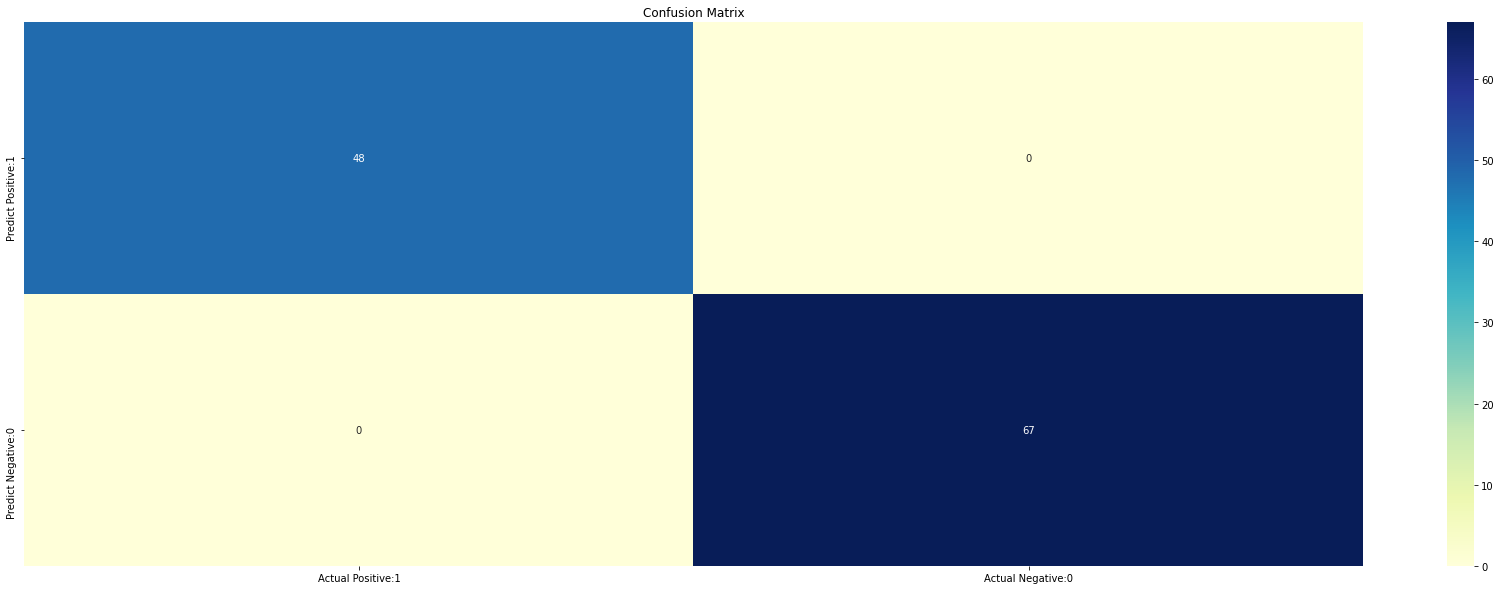

In [48]:
cm = confusion_matrix(y_test, y_pred_100)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu').set_title('Confusion Matrix')

As shown in the confusion matrix above, all predictive positives were actual positive and all predictive negatives were actual negatives. This could indicate the model was overfitted.

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_100))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        48
        True       1.00      1.00      1.00        67

    accuracy                           1.00       115
   macro avg       1.00      1.00      1.00       115
weighted avg       1.00      1.00      1.00       115



# Conclusion
This study set out to establish whether a statistical model could accurately predict the agent composition for every map during a game of Valorant. By creating an extensive webscraper using selenium, game data was scraped from tracker.gg. After cleaning the data, creating new features and creating normalization functions a statistic model was developed, showing the win chance for every map, agent and user. The outcome was that the statistical model increased the expected win rate per map by 15% on average by suggesting high performing agents per user. To predict if a match was won or lost, a machine learning model was adapted. The random forest that was chosen for the machine learning model predicted the outcome of a match with a 100% accuracy. This strongly indicates that the model overfit. This could be due to the X parameter being a Boolean, or because of the limited amount of entries per map. It also provided an insight in which categorical labels were most important to the random tree selection, these being the result_difference, combat_score and result indication, all metrics that showed personal good match. The agent and map columns proved not to be important at all. The problem with this predictive model was that it could only provide a prediction after the match was played, meanwhile the statistical model could be consulted prior to the match by providing insight into what is the highest rating agent per user. This resulted in a preference towards the statistical model, which could be used as a tool to become better as a team.